# Rapport synthétique projet machine learning
##### Ceci est une synthèse, c'est à dire dans les grandes lignes ce que nous avons eu l'occasion de faire pour ce projet. Vous pourrez retrouver tout le cheminement dans un notebook beaucoup plus gros ci-joint.

*Par Mouslihou Chérif Haidara et Sanchez Wenceslas*

*__Pseudo RAMP:__ Orlogskapten*

----
Le but du projet est d'améliorer la prédiction du nombre de passager pour les vols US, à l'aide de nouvelles données.
Voici donc les résutats importants (RMSE) et le nom des soumissions sur la plateforme RAMP: 



|  | Faux résultat | Meilleur résultat | Avec nos données actuelles |
| --- | --- | --- | --- |
| RMSE RAMP | 0.00 | 0.266 | 0.285 |
| Nom de la soumission | Ne_Pas_Regarder | hardcore_testingv15 | MoSEF_AHOuAhou_v6 |



- Faux résultat: __CE SCORE N'EST PAS A PRENDRE EN COMPTE CAR NOUS AVONS TRICHE__ ; on a essayé de voir s'il était possible de récupérer les fichiers de test et de train dans la machine, et de les ressortir. Initialement, nous en avions marre de voir certaines personnes récupérer le code du premier sur la plateforme et uniquement rajouter des zéros aux hyperparamètres, pour battre le premier du classement.

- Meilleur résultat: ce score résulte des premières soumissions que nous avons effectué, sans avoir rajouté énormément de données. De plus, nous n'avions pas fait de feature selection. La particularité du dataset utilisé est que nous avons appliqué toutes les données météoroloiques sur l'aéroport de départ et sur celui d'arrivée. On avait donc énormément de feature. Et peu importe notre méthode de sélection des variables, nous n'arrivions pas à battre le RMSE du modèle contenant toutes les variables.

- Avec nos nouvelles données: ce score a été obtenu avec un nouvel ajout de données qui nous semblaient pertinents pour prédire le nombre de passager par vol. Néanmoins, le score est plus élevé; et il est d'autant plus élevé si on a peu de variable. On ne sait pas pourquoi, mais de toutes nos soumissions, celles avec le plus de variable remportaient haut la main les meilleurs scores sur RAMP. Si notre score n'est pas à la hauteur du premier, c'est probablement lié au fait que nous n'avons pas passé autant de temps à choisir un modèle pertinent par rapport à nos premières soumissions.

##### Ce que vous aurez l'occasion de voir dans cette synthèse et dans le notebook ci-joint c'est la construction et la modélisation pour arriver à la soumission `MoSEF_AHOuAhou_v6`.

----
Dans un premier temps, nous avions rajouté:

- la localisation des aéroports [(disponible ici)](https://simplemaps.com/data/us-cities)

- le prix du pétrole laggué de 1, 3 et 6 mois avant la date de départ [(disponible sur Kaggle)](https://www.kaggle.com/mabusalah/brent-oil-prices)

- si le jour du départ ou bien les 7 prochains jours sont des jour fériers dans l'état de départ

- la météo au départ et à l'arrivée (température min, max etc.)

- la population dans la ville de départ (associée à l'aéroport) et d'arrivée

- si il y a une base militaire

- et enfin le fuseau horaire

A partir de cette base, nous avons commencé à transformer nos features et à modéliser. C'est d'ailleurs avec ce dataset que nous avons eu notre meilleur RMSE (=0.268) sur RAMP (submission= hardcore_testing_v15). Mais, nous n'étions pas satisfait pour plusieurs raisons:

1. nous n'avions pas fait de feature selection, et surtout quand on sélectionné les variables avec un Lasso, une Random Forest ou bien un LightGBM, nos modèles étaient moins performant (en terme de minimisation de la RMSE).

2. nous avions d'autres idées de données à récupérer / nous n'avions pas exploité une partie de nos données.

3. nous voulions avoir une RMSE encore plus faible.

__C'est pourquoi__ nous avons construit un autre dataset, comprenant cette fois-ci en plus:

- le nombre de passager et de siège par trajet d'aéroport [disponible ici sur le site Bureau of Transportations Statistics](https://www.transtats.bts.gov/Fields.asp)

- le prix du billet moyen par état et par semestre [disponible ici sur le site Bureau of Transportations Statistics](https://www.transtats.bts.gov/AverageFare/)

- des données plus précises sur la population [disponible ici sur le site Census Bureau](https://www.census.gov/). A propos de ces nouvelles données, initialement, nous avions uniquement la population de la ville mais en 2017. Maintenant, nous avons les véritables données de population entre 2011-2013, mais cette fois-ci uniquement par états. Mais on trouve ça plus interessant d'avoir une variable liée à la démographie, qui puisse varier pour l'aéroport au cours du temps, et pas avoir uniquement la même valeur pour chaque occurence d'aéroport.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import math

sns.set()
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

In [2]:
data= pd.read_csv("data/final_dataset.csv")

In [3]:
data.shape

(8902, 160)

In [4]:
data.head()

,WeeksToDeparture,std_wtd,Price1,Price3,Price6,Vacances,Average Fare ($),D-A_distance,diff_pop,y_2011,y_2012,y_2013,m_1,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10,m_11,m_12,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,wd_0,wd_1,wd_2,wd_3,wd_4,wd_5,wd_6,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9,w_10,w_11,w_12,w_13,w_14,w_15,w_16,w_17,w_18,w_19,w_20,w_21,w_22,w_23,w_24,w_25,w_26,w_27,w_28,w_29,w_30,w_31,w_32,w_33,w_34,w_35,w_36,w_37,w_38,w_39,w_40,w_41,w_42,w_43,w_44,w_45,w_46,w_47,w_48,w_49,w_50,w_51,w_52,d_ATL,d_BOS,d_CLT,d_DEN,d_DFW,d_DTW,d_EWR,d_IAH,d_JFK,d_LAS,d_LAX,d_LGA,d_MCO,d_MIA,d_MSP,d_ORD,d_PHL,d_PHX,d_SEA,d_SFO,a_ATL,a_BOS,a_CLT,a_DEN,a_DFW,a_DTW,a_EWR,a_IAH,a_JFK,a_LAS,a_LAX,a_LGA,a_MCO,a_MIA,a_MSP,a_ORD,a_PHL,a_PHX,a_SEA,a_SFO,D-A_distance*2,D-A_distance*3,Average Fare ($)*2,PASSENGERS,SEATS,nb_passengers
0,12.875000,9.812647,110.339524,125.445455,107.870500,0.0,392.504118,1285.250403,-12784939.0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.651869e+06,2.123065e+09,154059.483009,7228.583333,8038.500000,12.331296
1,14.285714,9.466734,113.356087,95.155714,125.445455,0.0,261.838741,990.537032,-2400449.0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9.811636e+05,9.718789e+08,68559.526081,4267.944444,5009.277778,10.775182
2,10.863636,9.035883,112.863684,102.618571,119.421667,1.0,320.946169,1354.641049,-32550281.0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1.835052e+06,2.485837e+09,103006.443400,4007.050000,4630.550000,11.083177
3,11.480000,7.990202,112.833810,116.973500,123.258889,1.0,378.078061,942.326564,-3045789.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,8.879794e+05,8.367665e+08,142943.019852,3831.937500,4555.875000,11.169268
4,11.450000,9.517159,110.686000,110.768095,110.219545,0.0,320.958300,1536.901253,-32550281.0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2.362065e+06,3.630261e+09,103014.230490,5498.000000,6709.636364,11.269364


### Feature selection

On a 159 colonnes (hors la variable cible). Il est donc nécessaire de faire de la sélection de variable. On a décidé d'utiliser 2 méthodes:

- une régression Lasso, pour sélectionner entre 20-30 features (on ajuste le $\alpha$ pour avoir ce nombre de variable)

- un LightGBM, avec la feature importance, c'est à dire qu'on comptabilise combien de fois nos variables ce sont retrouvés dans nos arbres. Plus une variable apparaît souvent, plus cette variable sera considéré comme importante pour prédire la cible.

In [5]:
dataset= data.copy()
y_array= data.pop("nb_passengers")

scaler= MinMaxScaler()
data_scaled= scaler.fit_transform(data)

lasso001 = Lasso(alpha=0.01, max_iter= 1000000)
lasso001.fit(data_scaled, y_array)
coeff_used001 = np.sum(lasso001.coef_!=0)
# data_l4.head()

print(coeff_used001)
null_coef= lasso001.coef_ != 0

col_name= np.array([col for col in data.columns])
good_col= col_name[null_coef]
good_col

29


array(['WeeksToDeparture', 'Vacances', 'D-A_distance', 'y_2011', 'y_2013',
       'm_10', 'm_12', 'wd_0', 'wd_1', 'wd_3', 'wd_5', 'wd_6', 'w_1',
       'w_47', 'w_52', 'd_ATL', 'd_LAS', 'd_LAX', 'd_LGA', 'd_ORD',
       'd_SFO', 'a_JFK', 'a_LAS', 'a_LAX', 'a_LGA', 'a_ORD', 'a_SFO',
       'PASSENGERS', 'SEATS'], dtype='<U18')

In [6]:
cat_col= [col for col in data.columns if data[col].nunique() <= 2]
num_col= [col for col in data.columns if col not in cat_col]

Plot feature importance…


<Figure size 720x720 with 0 Axes>

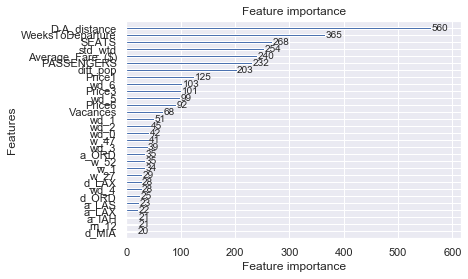

In [7]:
d_train = lgb.Dataset(data, label= y_array)

param = {"max_depth": 5, "learning_rate" : 0.1, "num_leaves": 900, "n_estimators": 200}

model2 = lgb.train(params= param, train_set= d_train, categorical_feature= cat_col)

print("Plot feature importance…")

fig= plt.figure(figsize= (10, 10))
ax = lgb.plot_importance(model2, max_num_features= 30)
plt.show()

good_features= ["D-A_distance", "WeeksToDeparture", "SEATS", "PASSENGERS", "diff_pop", "Average Fare ($)"
                , "Price1", "wd_5", "wd_6", "Price3", "Price6", "Vacances", "w_47", "a_ORD"
                , "d_LAX", "w_52", "wd_0", "w_1", "wd_1", "wd_3", "d_LAX", "w_27"
                , "a_LAX", "a_LAS", "y_2013", "d_ORD", "a_MCO", "a_LGA"
               ]

### Rapide EDA

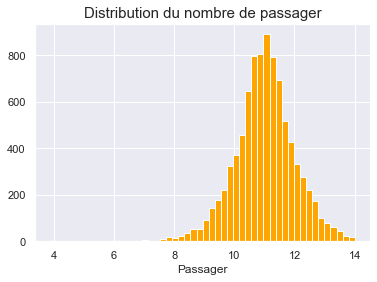

In [8]:
# dataset["nb_passager"]= y_array

fig= plt.figure(figsize= (6, 4))
plt.hist(dataset["nb_passengers"], bins=50, color="orange")
plt.title("Distribution du nombre de passager", fontsize= 15, fontweight= 20)
plt.xlabel("Passager")
plt.show()

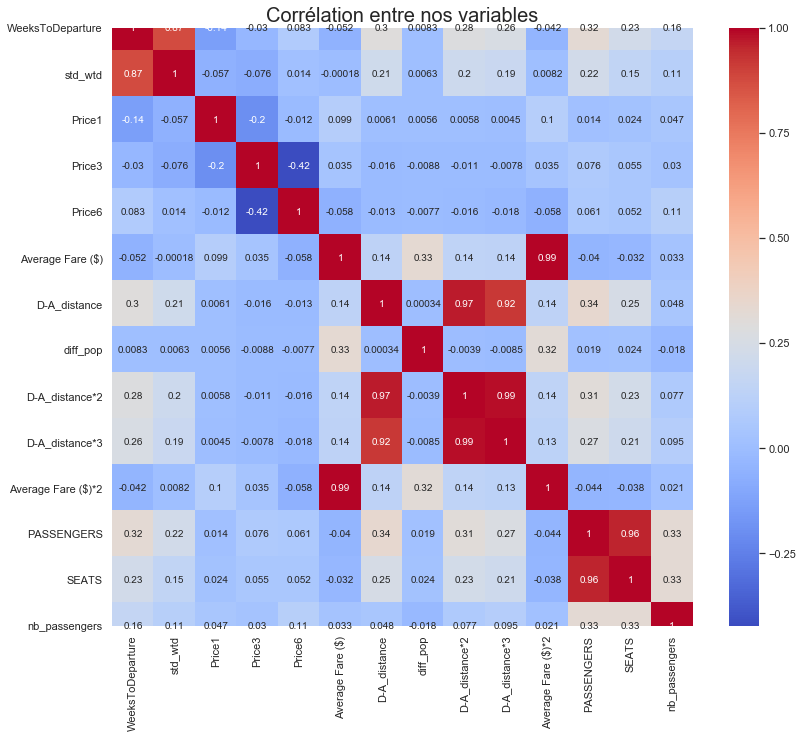

In [9]:
plt.figure(figsize=(13,11))
cor = dataset[num_col+["nb_passengers"]].corr()
sns.heatmap(cor, annot=True, cmap='coolwarm')
plt.title("Corrélation entre nos variables", fontsize= 20)
plt.show()

#### Remarque:

- forte corrélation entre le nombre de semaine précédent la réservation et son écart-type
- forte corrélation entre mes distances
- forte corrélation entre mes prix des billets
- forte corrélation entre nombre de passager et nombre de siège

In [10]:
def hist_cat2(col):
    v_1= dataset[dataset[col] == 1]["nb_passengers"].values
    v_0= dataset[dataset[col] == 0]["nb_passengers"].values

    plt.hist(v_0, bins= 50, label= "{}= 0".format(col))
    plt.hist(v_1, bins= 50, label= "{}= 1".format(col))
    
    plt.title(col)
    plt.legend()
    plt.show()

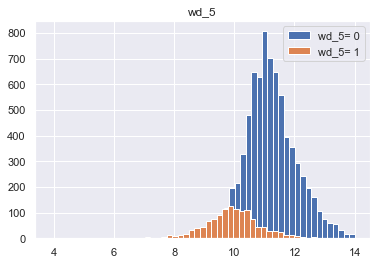

In [11]:
hist_cat2("wd_5")

#### Remarque: 

La variable wd_5 (= samedi) est une variable qui est ressortie avec le Lasso et le LightGBM. On se rend compte que la distribution du nombre de passenger est différente que l'on soit un samedi ou non. Elle a probablement un rôle à jouer dans la prédiction du nombre de passager.

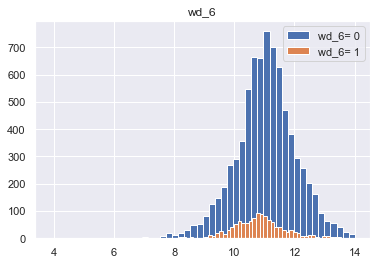

In [12]:
hist_cat2("wd_6")

#### Remarque:

A côté, le fait d'être dimanche était aussi ressorti, mais on se rends compte que la distribution n'est pas différentiable.

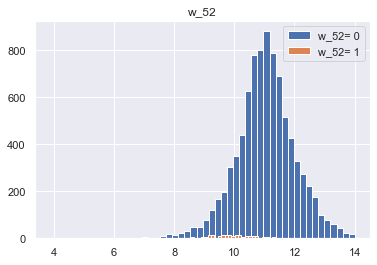

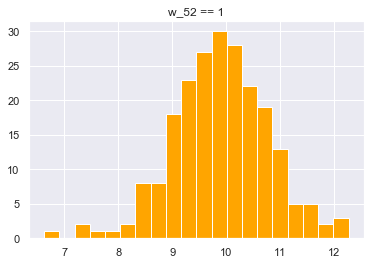

In [13]:
hist_cat2("w_52")

v_0= dataset[dataset["w_52"] == 1]["nb_passengers"].values
plt.hist(v_0, bins= 20, label= "{}= 1".format("w_52"), color= "orange")
plt.title("w_52 == 1")
plt.show()

#### Remarque:

Voici une limite à notre dataset, certaines modalités sont rares, de sorte que l'on arrive même pas à représenter notre histogramme.

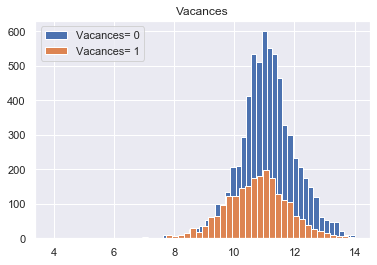

In [14]:
hist_cat2("Vacances")

In [15]:
def reg(col):
    X_test= data[col].values
    intercept= np.repeat(1, len(X_test))
    X= np.column_stack((intercept, X_test))

    linear_regressor = LinearRegression()  
    linear_regressor.fit(X, y_array) 
    Y_pred = linear_regressor.predict(X)

    plt.scatter(X_test, y_array)
    plt.plot(X_test, Y_pred, color='red')
    plt.title("Lien entre Y et {}".format(col))
    plt.xlabel(col)
    plt.ylabel("Y")
    plt.show()

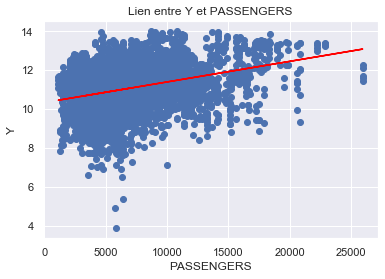

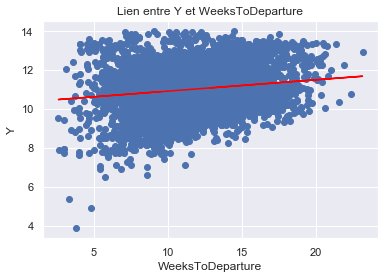

In [16]:
# print(data["PASSENGERS"].describe())
reg("PASSENGERS")
reg("WeeksToDeparture")
# reg("SEATS")

#### Remarque: 

Pour SEATS et PASSENGERS, on a probablement des valeurs extrêmes (à vérifier).

Comme nous l'avons montré avec la matrice de corrélation, PASSENGERS et SEATS sont corrélés possitivement à notre variable cible, weekstodeparture aussi mais la pente est un peu plus faible.

Les variables SEATS et PASSENGERS sont les variables les plus corrélées, ce qui ne semble pas déconnant, étant donné que le nombre de passager et le nombre de siège disponibles entre un aéroport et un autre sur un semestre est forcément lié au nombre de passager sur un trajet.

### Fast Modélisation

In [17]:
X_train, X_test, y_train, y_test= train_test_split(data, y_array, train_size= 0.8)

model= lgb.LGBMRegressor(boosting_type= "gbdt"
                                 , colsample_bytree= 0.5
                                 , learning_rate= 0.09
                                 , n_estimators= 5000
                                 , num_leaves= 30
                                 , reg_alpha= 0
                                 , reg_lambda= 0.05
                                 , subsample= 1
                                 , max_depth= -1
                                )

model.fit(X_train, y_train)

prediction1= model.predict(X_test)
print("RMSE: %.2f"
      % math.sqrt(np.mean((prediction1 - y_test) ** 2)))

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
              importance_type='split', learning_rate=0.09, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=5000, n_jobs=-1, num_leaves=30, objective=None,
              random_state=None, reg_alpha=0, reg_lambda=0.05, silent=True,
              subsample=1, subsample_for_bin=200000, subsample_freq=0)

In [39]:
X_train, X_test, y_train, y_test= train_test_split(data[good_features], y_array, train_size= 0.8)

model= lgb.LGBMRegressor(boosting_type= "gbdt"
                                 , colsample_bytree= 0.8
                                 , learning_rate= 0.1
                                 , n_estimators= 3000
                                 , num_leaves= 20
                                 , reg_alpha= 0
                                 , reg_lambda= 0.15
                                 , subsample= 0.9
                                 , max_depth= 3
                                )
model.fit(X_train, y_train)

prediction1= model.predict(X_test)
print("RMSE: %.2f"
      % math.sqrt(np.mean((prediction1 - y_test) ** 2)))

RMSE: 0.40
